In this notebook, we implement a classifier to distinguish among different fruit species using their images as input data based on Convolution Neural Networks

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.autograd import Variable

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

## Data Loading and Preprocessing

In [2]:
#Load the dataset and transform into tensors
from torchvision import datasets, transforms

dataset_path=datasets.ImageFolder(root='fruits/Training/',
                                 transform=transforms.Compose(
                                     [transforms.ToTensor()]
                                 )
                                )

## Spliting dataset into train and test (80% training and 20% Test)

In [3]:
from torch.utils.data.sampler import SubsetRandomSampler

split = int(0.8* len(dataset_path))
index_list = list(range(len(dataset_path)))
np.random.shuffle(index_list)

train_idx, test_idx = index_list[:split], index_list[split:]

## create sample objects using SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

## create iterator objects for train and test datasets
train_loader = torch.utils.data.DataLoader(dataset_path, 
                                           batch_size = 256,
                                           sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(dataset_path, 
                                           batch_size = 256,
                                           sampler=test_sampler)

print(f'Total Number of Examples: {len(dataset_path)}')
print(f'Number of training Examples: {len(train_sampler)}')
print(f'Number of testing Examples: {len(test_sampler)}')

Total Number of Examples: 8166
Number of training Examples: 6532
Number of testing Examples: 1634


In [4]:
Classes_num=len(train_loader.dataset.classes)
print(f'Number of Classes: {Classes_num}')
print(f'Classes Name: {train_loader.dataset.classes}')

Number of Classes: 15
Classes Name: ['Rambutan', 'Raspberry', 'Redcurrant', 'Salak', 'Strawberry', 'Strawberry Wedge', 'Tamarillo', 'Tangelo', 'Tomato 1', 'Tomato 2', 'Tomato 3', 'Tomato 4', 'Tomato Cherry Red', 'Tomato Maroon', 'Walnut']


Example: 
(100, 100, 3)


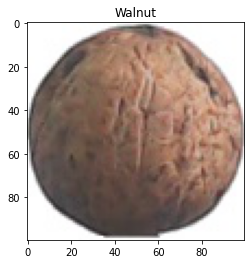

In [5]:
print("Example: ")
i1, l1 = next(iter(train_loader))
plt.title(train_loader.dataset.classes[l1[0]])
plt.imshow(np.array(i1[0].permute(1,2,0)));
print(np.array(i1[0].permute(1,2,0)).shape)

## Convolution Neural Network

<img src="CNN.png">

## Layer Dimensions

Below formula shown to check the size of layer by given parameters.

<br>
<center>
<font size="5">
$n_{out} = \left[\frac{n_{in} + 2p - k}{s}\right]$
</font>


<font size="2">
    
$n_{out}$: number of input features

$n_{out}$ : number of output features

$k$ : convolution kernel size

$p$ : convolution padding size

$s$ : convolution stride size
</font>


### Input Size
The images are 3x100x100, i.e., 3 channels (red, green, blue) each of size 100x100 pixels.

### First Convolutional Layer
The first convolutinoal layer expects 3 input channels and will convolve 6 filters each of size 3x9x9. Since padding is set to 0 and stride is set to 1, the output size is 6x92x92, because  (100-9)+1 = 92.

### First Max-Pooling Layer
The first down-sampling layer uses max pooling with a 2x2 kernel and stride set to 2. This effectively drops the size the size from 6x92x92 to 6x46x46.

### Second Convolutional Layer 
The second convolutional layers expects 6 input channels and will convolve 8 filters each of size 6x7x7. Since padding is set to 0 and stride is set to 1, the output size is 8x40x40: (46-7)+1 = 40.

In [6]:
from torch import nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, 
            out_channels=6,
            kernel_size=9,
            stride=1,
            padding=0
        )
        
        self.conv2 = nn.Conv2d(
            in_channels=6, 
            out_channels=8,
            kernel_size=7,
            stride=1,
            padding=0
        )
        
        self.conv3 = nn.Conv2d(
            in_channels=8, 
            out_channels=16,
            kernel_size=5,
            stride=1,
            padding=0
        )
        
        self.fc1 = nn.Linear(8*8*16, 300)
        self.fc2 = nn.Linear(300, Classes_num)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,2,2)
        
        x = x.view(-1, 8*8*16)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)
    
model = Model()
model.cuda(device)

print(model)


Model(
  (conv1): Conv2d(3, 6, kernel_size=(9, 9), stride=(1, 1))
  (conv2): Conv2d(6, 8, kernel_size=(7, 7), stride=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=15, bias=True)
)


Define the loss function and the optimizer using the nn and optim package:

In [7]:
from torch import optim
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

## Model Training

In [8]:
epochs = 20
loss_array = []

for epoch in range(1, epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data).to(device), Variable(target).to(device)
        
        #set the gradients to zero 
        #before starting to do backpropragation
        optimizer.zero_grad() 
        
        ## 1. forward propagation
        model_out = model(data)
        
        ## 2. loss calculation
        loss = criterion(model_out, target)
        
        ## 3. backward propagation
        loss.backward()
        
        ## 4. weight optimization
        optimizer.step()
        
        loss_array.append(loss.item())
        if batch_idx % len(train_loader)-1 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 1, Loss: 2.707366466522217
Epoch 2, Loss: 2.681840419769287
Epoch 3, Loss: 2.458961248397827
Epoch 4, Loss: 1.5965619087219238
Epoch 5, Loss: 0.5515910387039185
Epoch 6, Loss: 0.3364236652851105
Epoch 7, Loss: 0.21898730099201202
Epoch 8, Loss: 0.12273412942886353
Epoch 9, Loss: 0.09790030866861343
Epoch 10, Loss: 0.08181439340114594
Epoch 11, Loss: 0.04720715433359146
Epoch 12, Loss: 0.06883605569601059
Epoch 13, Loss: 0.03427663445472717
Epoch 14, Loss: 0.039653755724430084
Epoch 15, Loss: 0.029556473717093468
Epoch 16, Loss: 0.03181301802396774
Epoch 17, Loss: 0.020267045125365257
Epoch 18, Loss: 0.022628912702202797
Epoch 19, Loss: 0.014752998948097229


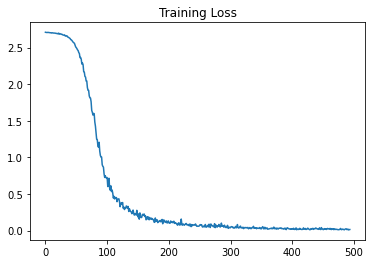

In [9]:
%matplotlib inline
plt.plot(loss_array)
plt.title("Training Loss")
plt.show()

## Model Testing

In [10]:
dataiter = iter(test_loader)
data, labels = dataiter.next()
data, target = Variable(data).to(device), Variable(target).to(device)

output = model(data)
_, preds_tensor = torch.max(output, 1)
preds_tensor=preds_tensor.cpu()
preds = np.squeeze(preds_tensor.numpy())
print(f'Actual: {np.array(labels[:10])}')
print(f'Predicted: {preds[:10]}')

Actual: [ 2 14  3  7  3  4  9 14  2 11]
Predicted: [ 2 14  3  7  3  4  9 14  2 11]


In [11]:
correct = 0
test_loss = 0

for data, target in test_loader:
    data, target = Variable(data).to(device), Variable(target).to(device)
    net_out = model(data)
    
    test_loss += criterion(net_out, target).item()
    pred = net_out.data.max(1)[1] #get index of the max log-probability
    correct += pred.eq(target.data).sum()
    
test_loss /= len(test_loader.dataset)

print(f'Average loss: {test_loss}')
print(f'Accuracy: {np.array(100.*correct.cpu() / len(test_sampler))}%')
print(f'Total Test Examples: {len(test_sampler)}')
print(f'Correct predicted examples: {int(correct)}')

Average loss: 1.3433007339570793e-05
Accuracy: 99%
Total Test Examples: 1634
Correct predicted examples: 1631
